In [1]:
import os
import numpy as np
import torch
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

# Import functions and classes from your project modules
from data_loader import load_and_label_data, normalize_segments, train_val_test_split_data, SensorDataset, LABEL_MAPPING
from train import eval_model
# Import the model classes so we can instantiate the model architecture
from models.cnn_model import CNNModel
from models.lstm_model import LSTMModel
from models.hybrid_model import HybridCNNSoftmaxModel
from models.hybrid_moe_model import HybridMixtureOfExpertsModel

# --- Load Config ---
config_path = os.path.join("config", "hybrid.yaml")  # adjust config name if needed
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Get necessary config parameters
model_type = config.get("model_type", "hybrid").lower()
num_classes = config.get("num_classes", 6)
window_size = config.get("window_size", 100)  # For augmentation
stride = config.get("stride", 10)
batch_size = config.get("batch_size", 32)
best_model_path = config.get("model_save_path", "./output_model/hybrid.pth")
data_dir = "./dataset/train"  # Adjust if needed

# --- Load & Augment Data ---
data_list, labels = load_and_label_data(data_dir, window_size=window_size, stride=stride)
segments = np.array(data_list)
print("Augmented data shape:", segments.shape)  # (n_samples, window_size, n_features)
segments, scaler = normalize_segments(segments)

# Split data into train, val, test
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_data(
    segments, labels, test_size=0.2, val_size=0.2
)
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# --------------------------------------------------
# Combine Train, Val, and Test sets for final metrics
# --------------------------------------------------
X_all = np.concatenate([X_train, X_val, X_test], axis=0)
y_all = np.concatenate([y_train, y_val, y_test], axis=0)
print("Combined dataset shape:", X_all.shape)

# Create DataLoader for the combined dataset
all_dataset = SensorDataset(X_all, y_all, one_hot=False)
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False)

# --- Instantiate and Load the Best Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_features = X_train.shape[-1]  # number of sensor features
if model_type == "lstm":
    from models.lstm_model import LSTMModel
    model = LSTMModel(
        num_classes=num_classes,
        input_features=input_features,
        hidden_size=config.get('lstm_hidden_size', 128),
        num_layers=config.get('lstm_num_layers', 2),
        bidirectional=config.get('lstm_bidirectional', False),
        dropout=config.get('dropout', 0.5),
        weight_threshold=config.get('lstm_weight_threshold', 60),
        max_weight=config.get('lstm_max_weight', 1.2)
    ).to(device)
elif model_type == "hybrid":
    model = HybridCNNSoftmaxModel(
        num_classes=num_classes,
        window_size=window_size,
        input_features=input_features
    ).to(device)
elif model_type == "hybrid_moe":
    model = HybridMixtureOfExpertsModel(
        num_classes=num_classes,
        window_size=window_size,
        input_features=input_features
    ).to(device)
else:
    model = CNNModel(
        num_classes=num_classes,
        window_size=window_size,
        input_features=input_features
    ).to(device)

# Load saved model state
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print("Loaded best model from:", best_model_path)


Augmented data shape: (1389, 100, 6)
Train: 888, Val: 223, Test: 278
Combined dataset shape: (1389, 100, 6)
Loaded best model from: output_model/best_model.pth


/var/folders/1b/x02b24d16rbf3gjfvngp6hqw0000gn/T/ipykernel_58219/4171245525.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

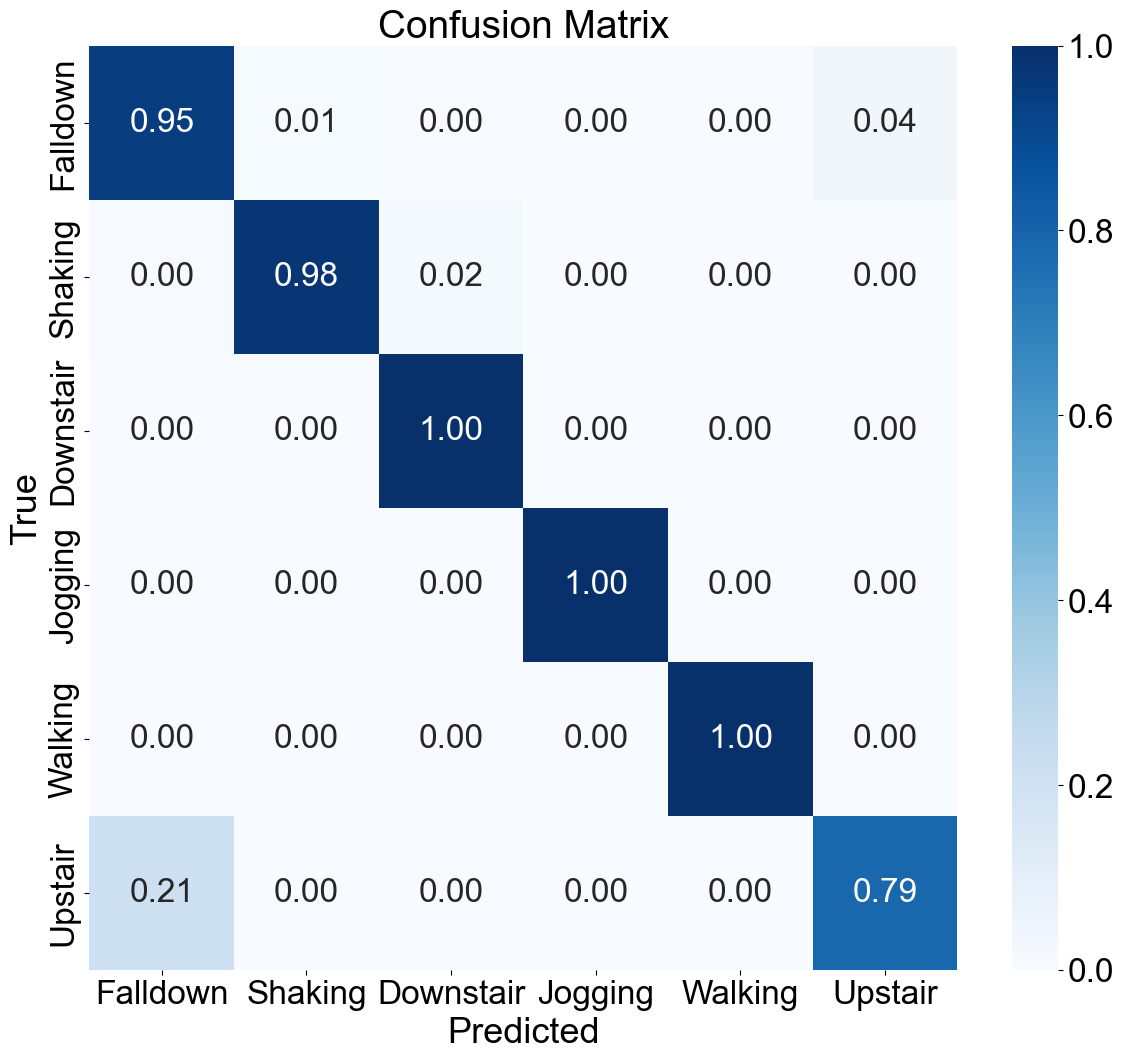

In [2]:

# --- Confusion Matrix on Combined Dataset ---
all_preds = []
all_true = []
with torch.no_grad():
    for inputs, labels in all_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(labels.numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_true, all_preds)

# Normalize the confusion matrix by row to balance the classes
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14,12))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 24  # Adjust the size as needed
capitalized_labels = [label.capitalize() for label in list(LABEL_MAPPING.keys())]
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels= capitalized_labels,
            yticklabels= capitalized_labels,
            annot_kws={"size": 24})
plt.xlabel("Predicted", fontsize=26)
plt.ylabel("True", fontsize=26)
plt.title("Confusion Matrix",fontsize=28)
plt.savefig("confusion_Matrix_Normalized.png", transparent=True)
plt.show()


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


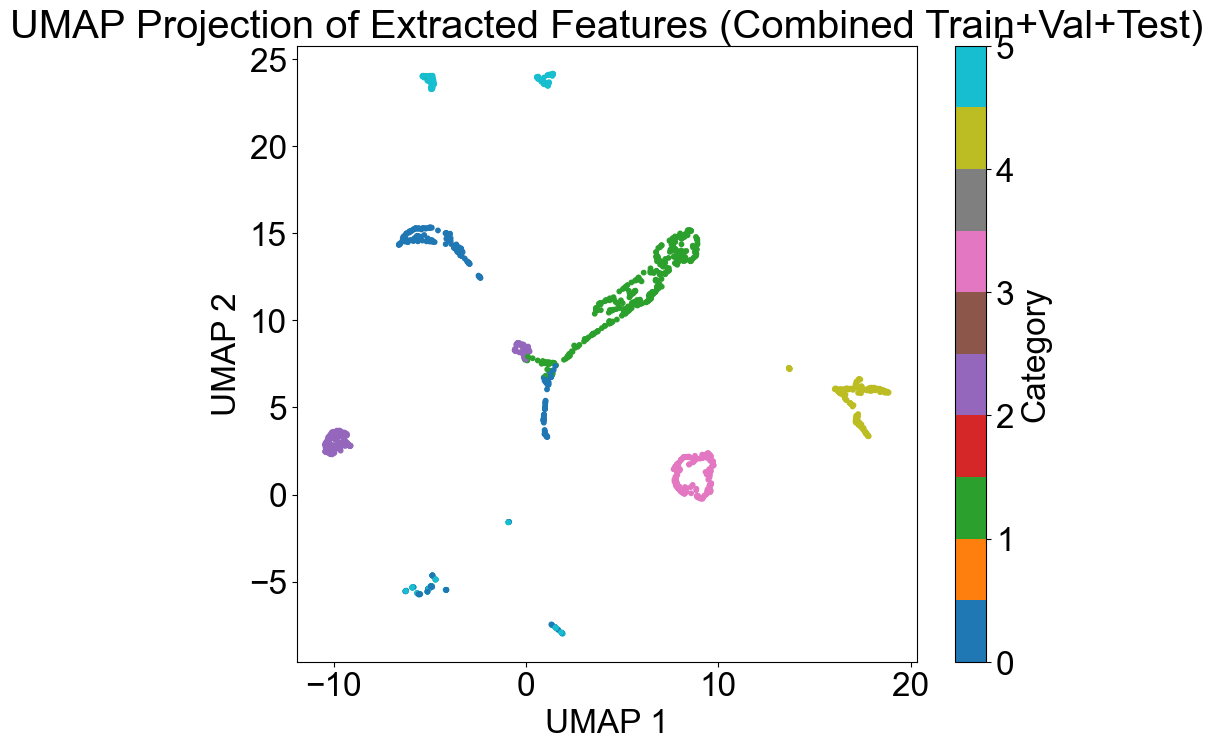

In [3]:
# --- Extract Features and Visualize with UMAP (Combined Dataset) ---
features_list = []
labels_list = []

def hook_fn(module, input, output):
    features_list.append(output.detach().cpu())

# Register a forward hook on the fc1 layer (adjust if model has a different architecture).
hook_handle = None
if hasattr(model, "fc1"):
    hook_handle = model.fc1.register_forward_hook(hook_fn)
else:
    print("Model does not have fc1 layer. Please adjust the hook accordingly.")

with torch.no_grad():
    for inputs, labels in all_loader:
        inputs = inputs.to(device)
        _ = model(inputs)
        labels_list.extend(labels.numpy())

if hook_handle is not None:
    hook_handle.remove()

if len(features_list) > 0:
    features = torch.cat(features_list, dim=0).numpy()
    
    # Use UMAP to reduce features to 2 dimensions (adjust parameters as needed)
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.05, metric='euclidean')
    embedding = reducer.fit_transform(features)
    
    plt.figure(figsize=(10,8))
    scatter = plt.scatter(embedding[:,0], embedding[:,1], c=labels_list, cmap="tab10", s=10)
    plt.colorbar(scatter, ticks=range(num_classes), label="Category")
    plt.title("UMAP Projection of Extracted Features (Combined Train+Val+Test)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
else:
    print("No features extracted for UMAP visualization.")

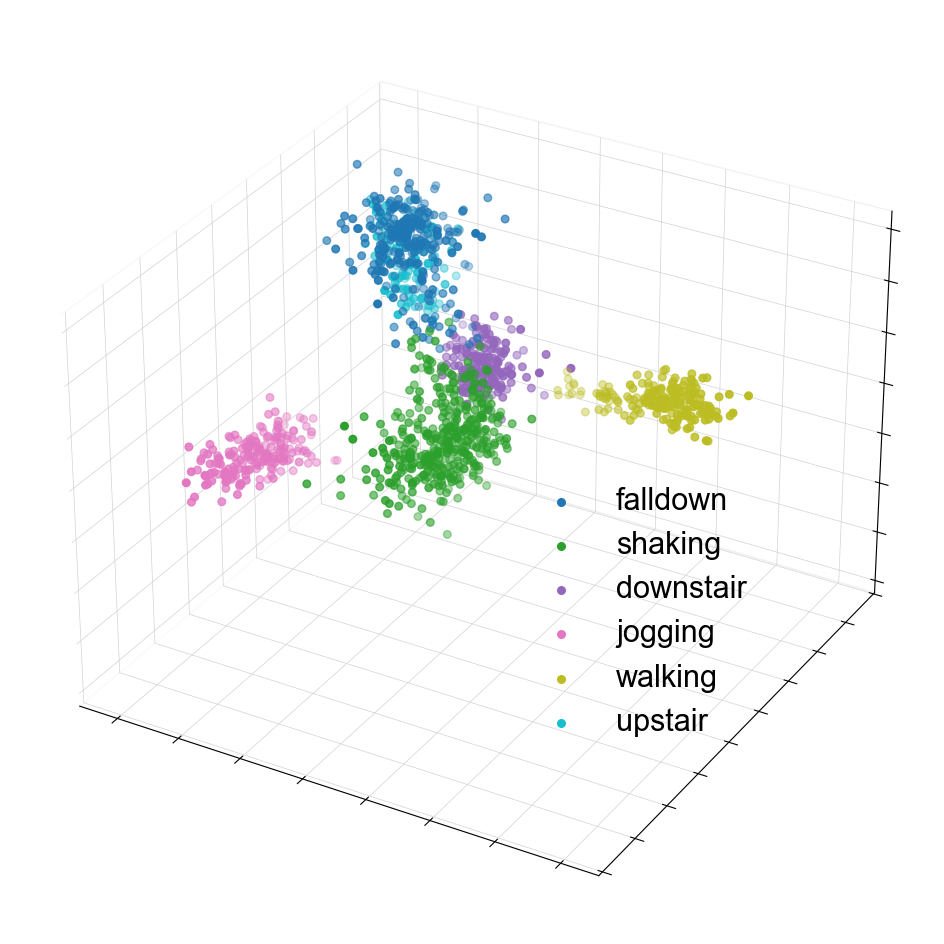

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import font_manager
from mpl_toolkits.mplot3d.art3d import Line3D
LABEL_MAPPING = {
    'falldown': 0,
    'shaking': 1,
    'downstair': 2,
    'jogging': 3,
    'walking': 4,
    'upstair': 5,
}

if len(features_list) > 0:
    # Convert to numpy arrays
    features = torch.cat(features_list, dim=0).numpy()  # (num_samples, feature_dim)
    labels_np = np.array(labels_list)
    
    # Create LDA with 3 components
    lda = LinearDiscriminantAnalysis(n_components=3)
    X_lda = lda.fit_transform(features, labels_np)  # shape: (num_samples, 3)
    
    # Prepare figure
    fig = plt.figure(figsize=(14, 12))
    fig.patch.set_facecolor('white')  # figure background
    ax = fig.add_subplot(111, projection='3d')
    
    # Set pane backgrounds to white
    ax.xaxis.pane.set_facecolor('white')
    ax.yaxis.pane.set_facecolor('white')
    ax.zaxis.pane.set_facecolor('white')
    
    # Enable grid lines, but set them to a light gray color
    ax.grid(True)
    # Adjust the grid line style for each axis
    ax.xaxis._axinfo["grid"]['color'] = "lightgray"
    ax.xaxis._axinfo["grid"]['linewidth'] = 0.5
    ax.yaxis._axinfo["grid"]['color'] = "lightgray"
    ax.yaxis._axinfo["grid"]['linewidth'] = 0.5
    ax.zaxis._axinfo["grid"]['color'] = "lightgray"
    ax.zaxis._axinfo["grid"]['linewidth'] = 0.5

    ax.xaxis._axinfo["axisline"]["color"] = (0, 0, 0, 0)  # Black with 0 alpha
    ax.yaxis._axinfo["axisline"]["color"] = (0, 0, 0, 0)
    ax.zaxis._axinfo["axisline"]["color"] = (0, 0, 0, 0)


    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])


    # Reverse the label mapping to get names from IDs
    rev_mapping = {v: k for k, v in LABEL_MAPPING.items()}
    unique_labels = sorted(np.unique(labels_np))
    cmap = plt.get_cmap("tab10", len(unique_labels))

    
    # Plot each label separately, adding a legend entry for each
    for i, label_id in enumerate(unique_labels):
        label_name = rev_mapping.get(label_id, f"Class {label_id}")
        idx = (labels_np == label_id)
        color = cmap(i)
        ax.scatter(
            X_lda[idx, 0], X_lda[idx, 1], X_lda[idx, 2],
            color=color, label=label_name, s=30
        )
    
    # Create a legend without a background box
    prop = font_manager.FontProperties(family='Arial', size=22)
    ax.legend(loc=(0.55,0.2), frameon=False, prop=prop) #(0.65,0.62) # (0.55,0.2)
    
    plt.savefig("LDA_plot.png", transparent=True)
    plt.show()
    
else:
    print("No features extracted for LDA visualization.")


/opt/anaconda3/envs/nnenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1389, 3)


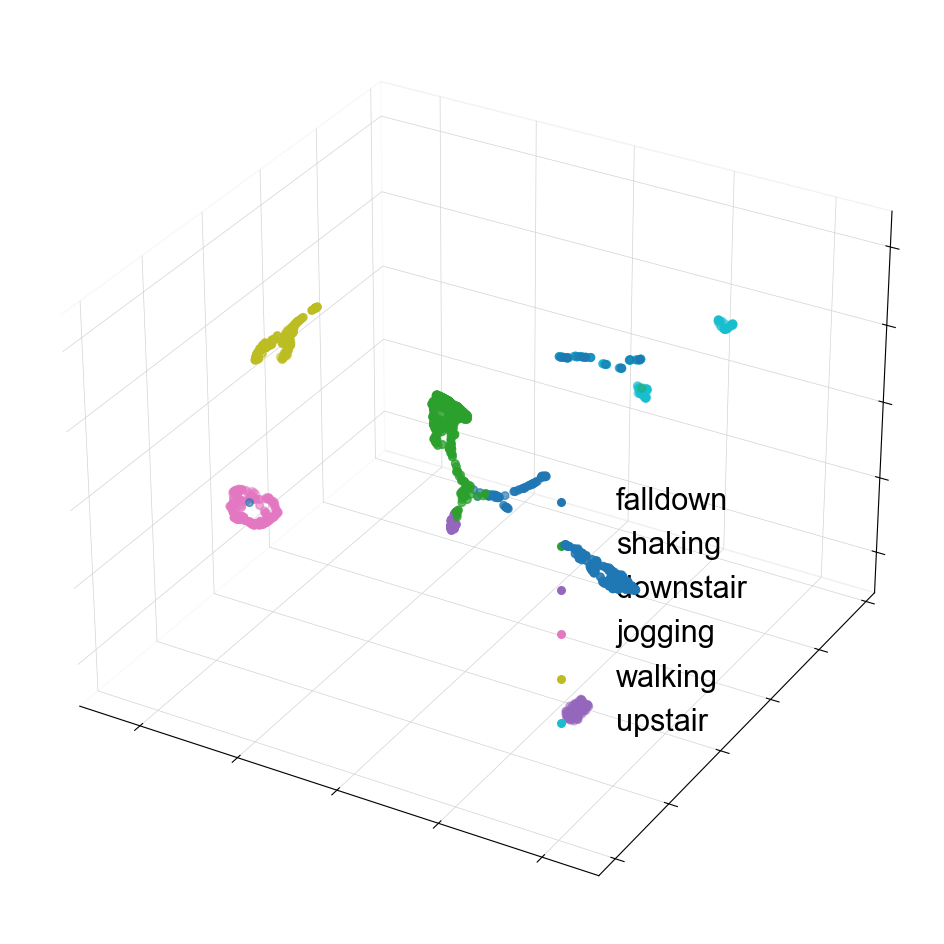

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
from matplotlib import font_manager

# Define your label mapping (should match your data)
LABEL_MAPPING = {
    'falldown': 0,
    'shaking': 1,
    'downstair': 2,
    'jogging': 3,
    'walking': 4,
    'upstair': 5,
}

if len(features_list) > 0:
    # Convert the list of features (PyTorch tensors) to a numpy array
    features = torch.cat(features_list, dim=0).numpy()  # (num_samples, feature_dim)
    labels_np = np.array(labels_list)
    
    # Create UMAP reducer with 3 components
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
    X_umap = reducer.fit_transform(features)  # shape: (num_samples, 3)
    
    print("UMAP embedding shape:", X_umap.shape)
    
    # Prepare the figure
    fig = plt.figure(figsize=(14, 12))
    fig.patch.set_facecolor('white')  # Set figure background to white
    ax = fig.add_subplot(111, projection='3d')
    
    # Set pane backgrounds to white
    ax.xaxis.pane.set_facecolor('white')
    ax.yaxis.pane.set_facecolor('white')
    ax.zaxis.pane.set_facecolor('white')
    
    # Enable grid lines with light gray color and adjust line widths
    ax.grid(True)
    ax.xaxis._axinfo["grid"]['color'] = "lightgray"
    ax.xaxis._axinfo["grid"]['linewidth'] = 0.5
    ax.yaxis._axinfo["grid"]['color'] = "lightgray"
    ax.yaxis._axinfo["grid"]['linewidth'] = 0.5
    ax.zaxis._axinfo["grid"]['color'] = "lightgray"
    ax.zaxis._axinfo["grid"]['linewidth'] = 0.5

    # Make the axis lines transparent
    ax.xaxis._axinfo["axisline"]["color"] = (0, 0, 0, 0)
    ax.yaxis._axinfo["axisline"]["color"] = (0, 0, 0, 0)
    ax.zaxis._axinfo["axisline"]["color"] = (0, 0, 0, 0)

    # Remove tick labels for a cleaner look
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Reverse the label mapping to get class names from IDs
    rev_mapping = {v: k for k, v in LABEL_MAPPING.items()}
    unique_labels = sorted(np.unique(labels_np))
    cmap = plt.get_cmap("tab10", len(unique_labels))
    
    # Plot each class separately with its corresponding color
    for i, label_id in enumerate(unique_labels):
        label_name = rev_mapping.get(label_id, f"Class {label_id}")
        idx = (labels_np == label_id)
        color = cmap(i)
        ax.scatter(
            X_umap[idx, 0], X_umap[idx, 1], X_umap[idx, 2],
            color=color, label=label_name, s=30
        )
    
    # Create a legend without a background box
    prop = font_manager.FontProperties(family='Arial', size=22)
    ax.legend(loc=(0.55, 0.2), frameon=False, prop=prop)
    
    plt.savefig("UMAP_plot.png", transparent=True)
    plt.show()
    
else:
    print("No features extracted for UMAP visualization.")
